<a href="https://colab.research.google.com/github/lior0110/main/blob/master/DJI_test2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lior0110/main/blob/master/DJI_test2.ipynb)

In [0]:
import os 
if not os.path.exists('main'): os.system('git clone https://github.com/lior0110/main/')
os.chdir('main')

In [0]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# read the given data
data = pd.read_csv('DJI2.csv', parse_dates=True) # , index_col=0
data.head()

Date          Open  ...     Adj Close     Volume
0  2007-01-03  12459.540039  ...  12474.519531  327200000
1  2007-01-04  12473.160156  ...  12480.690430  259060000
2  2007-01-05  12480.049805  ...  12398.009766  235220000
3  2007-01-08  12392.009766  ...  12423.490234  223500000
4  2007-01-09  12424.769531  ...  12416.599609  225190000

[5 rows x 7 columns]

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3328 entries, 0 to 3327
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       3328 non-null   object 
 1   Open       3328 non-null   float64
 2   High       3328 non-null   float64
 3   Low        3328 non-null   float64
 4   Close      3328 non-null   float64
 5   Adj Close  3328 non-null   float64
 6   Volume     3328 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 182.1+ KB


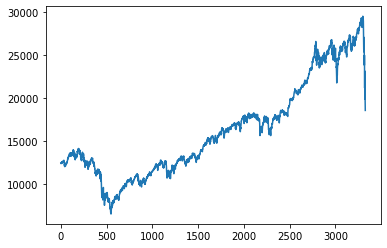

In [5]:
data['Adj Close'].plot()

In [0]:
# see if 'Adj Close' is the same as 'Close'
# if yes drop 'Adj Close'
test = data['Adj Close'] == data['Close']
if all(data['Adj Close'] == data['Close']):
    data = data.drop(columns='Adj Close')



In [7]:
data.head()


Date          Open  ...         Close     Volume
0  2007-01-03  12459.540039  ...  12474.519531  327200000
1  2007-01-04  12473.160156  ...  12480.690430  259060000
2  2007-01-05  12480.049805  ...  12398.009766  235220000
3  2007-01-08  12392.009766  ...  12423.490234  223500000
4  2007-01-09  12424.769531  ...  12416.599609  225190000

[5 rows x 6 columns]

In [8]:
data.tail()


Date          Open  ...         Close     Volume
3323  2020-03-17  20487.050781  ...  21237.380859  793060000
3324  2020-03-18  20188.689453  ...  19898.919922  871360000
3325  2020-03-19  19830.009766  ...  20087.189453  780300000
3326  2020-03-20  20253.150391  ...  19173.980469  872290000
3327  2020-03-23  19028.359375  ...  18591.929688  787970000

[5 rows x 6 columns]

In [9]:
data.columns
data.shape

(3328, 6)

In [0]:
# get data in windows format

window_len = 100 # window length to use for prediction
useVolume = True

windows = []

for i in range(data.shape[0]-window_len+1):
    windows.append(data[i:i+window_len])


In [11]:
windows[0].Close

0     12474.519531
1     12480.690430
2     12398.009766
3     12423.490234
4     12416.599609
          ...     
95    13542.879883
96    13539.950195
97    13525.650391
98    13441.129883
99    13507.280273
Name: Close, Length: 100, dtype: float64

In [0]:
# comparing two windows to get their distance 
def window_compare(window1, window2):
  win1 = window1.Close.values
  win2 = window2.Close.values
  dist = np.corrcoef(win1, win2)[1,0]
  return dist


In [0]:
# transform target window to resemble source window
def window_transform(source, target):
  target = target.Close.values
  source = source.Close.values

  target = (target - target.mean()) / target.std()
  target = target * source.std() + source.mean()

  transformed_window = target
  return transformed_window


In [14]:
window_compare(windows[1], windows[2])

0.9817382579497858

In [0]:
from scipy import signal

In [0]:
# finding the most similar windows
def find_best_windows(target_window_number, windows, num_best=1, leg=window_len, min_importance=0.5, lookback = 10000):
  dists = []
  start = 0 if (target_window_number-lookback)<0 else (target_window_number-lookback)
  for i in range(start, target_window_number-leg):
    dists.append(window_compare(windows[i], windows[target_window_number]))
  best_score = max(dists)
  if best_score >= min_importance:
    peaks, properties = signal.find_peaks(dists, distance=leg, height=min_importance)
    if len(peaks) <= num_best:
      best_windows = peaks
    else:
      best_windows = peaks[properties['peak_heights'].argsort()[-num_best:]]
  else:
    best_windows = np.array([dists.index(max(dists))])
  return best_windows, best_score

In [0]:
from matplotlib import animation, rc
from IPython.display import HTML

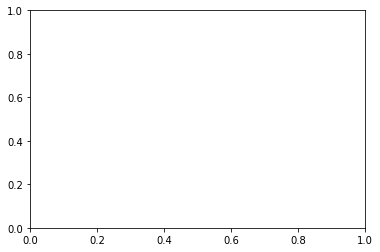

In [18]:
fig, ax = plt.subplots()

In [0]:
# initialization function: plot the background of each frame
def init():
    ax.plot([])
    return ax

In [0]:
# drawing the window and the similars

window_number = 500
num_best = 5

def draw_select(window_number, num_best, forward):
  # for window_number in range(500,data.shape[0]-int(forward*window_len)+1):
  src = data[window_number:window_number+int(forward*window_len)].Close.values
  x = data[window_number:window_number+int(forward*window_len)].index
  best_windows, best_score = find_best_windows(window_number, windows[:window_number+1], num_best=num_best)
  tar = window_transform(data[window_number:window_number+window_len],data[best_windows[0]:best_windows[0]+int(forward*window_len)])
  for i in range(1,len(best_windows)):
    add = window_transform(data[window_number:window_number+window_len],data[best_windows[0]:best_windows[0]+int(forward*window_len)])
    tar += add
  tar /= len(best_windows)

  ax.clear()

  ax.plot(x, tar, color = 'pink', label = 'Predicted Stock Price')
  ax.plot(x, src, color = 'blue', label = 'Real Stock Price')
  ax.axvline(x = x[window_len-1])
  ax.set_title
  ax.set_title('Stock Price Prediction')
  ax.set_xlabel('Time')
  ax.set_ylabel('Stock Price')
  ax.legend()

  return ax



In [0]:
num_best=5
forward=1.5
M = data.shape[0]-int(forward*window_len)+1
frames=range(M-200,M-100) # data.shape[0]-int(forward*window_len)+1

anim = animation.FuncAnimation(fig, draw_select, init_func=init, frames=frames,
                               fargs=(num_best, forward), interval=20, blit=False)

# Animation size has reached 20998677 bytes, exceeding the limit of 20971520.0. If you're sure you want a larger animation embedded, set the animation.embed_limit rc parameter to a larger value (in MB). This and further frames will be dropped.
# animation.embed_limit


In [0]:
# anim.save('knn_predict.mp4')

In [23]:
HTML(anim.to_jshtml())
